### Clustering examples
Starting in v0.4, AntPack provides a variety of algorithms for clustering small datasets and a highly scalable algorithm for clustering large datasets, together with a tool that makes it easy to manipulate multiple sequence alignments (MSAs) generated by AntPack. We'll illustrate all of these tools using some data that we wouldn't normally use for clustering since it's a fairly diverse collection of antibodies, but as we'll find it's easy to apply these same workflows to one of your own datasets.

This example uses Biopython, seaborn, scipy, sklearn and matplotlib, which are not required for AntPack (the only AntPack dependency is Numpy) but are useful for downstream analysis and visualization.

In [1]:
import os, gzip
import numpy as np
from antpack import SingleChainAnnotator, EMCategoricalMixture
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
from Bio import SeqIO
from sklearn.metrics import confusion_matrix
from scipy.stats.contingency import association

In [2]:
light_chains = []

with gzip.open(os.path.join("..", "tests", "test_data", "addtnl_test_data.fasta.gz"), "rt") as fhandle:
    for seqrec in SeqIO.parse(fhandle, "fasta"):
        # For now we'll just use the light chains...
        if "light" not in seqrec.name:
            continue
        light_chains.append(str(seqrec.seq))

First, let's use AntPack to align these sequences and convert them into an MSA.

In [3]:
annotator = SingleChainAnnotator()
annotations = annotator.analyze_seqs(light_chains)
msa_position_codes, msa = annotator.build_msa(light_chains, annotations)

In [4]:
print(msa_position_codes)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '65', '66', '67', '68', '69', '70', '71', '72', '74', '75', '76', '77', '78', '79', '80', '80A', '81', '82', '82A', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '120A', '121', '122', '123', '124', '125', '126', '127']


Next we'll make use of the ``build_distance_matrix`` function in SingleChainAnnotator / PairedChainAnnotator. This function constructs a distance matrix using Hamming distance for any region (the whole sequence, cdr, framework or a specific cdr or framework) that we specify. If we want the distance matrix to use both heavy and light chains, we can just construct a distance matrix for each and sum them. This function expects the sequences to have been aligned already and will reject a set of inputs that are not the same length.

In [5]:
# First we create a numpy array in which the distance matrix will be stored. We'll build two distance
# matrices for illustrative purposes.
full_sequence_distance_matrix = np.empty((len(msa), len(msa)))
framework_distance_matrix = np.empty((len(msa), len(msa)))

# Next, pass this to build_distance_matrix. Notice that for the chain argument we can pass either 
# L or K -- these are equivalent because this is light chain. We can also pass a 'scheme' which is
# a scheme (e.g. IMGT, Aho etc.) for defining CDRs. This can be different than the scheme used to
# number the antibodies (IMGT in this case) if we want to say number with IMGT and assign CDRs using
# Kabat definitions. scheme="" (the default) indicates to use the numbering scheme selected for
# the annotator when it was constructed.
annotator.build_distance_matrix(full_sequence_distance_matrix, msa, msa_position_codes,
                                chain="L", region="all", scheme="")
# Note that fmwk1 selects framework region 1; 'fmwk' would select all framework regions,
# 'cdr' all cdrs, 'cdr1' just cdr1 etc.
annotator.build_distance_matrix(framework_distance_matrix, msa, msa_position_codes,
                                chain="L", region="fmwk1", scheme="kabat")

There are a lot of clustering algorithms in Scipy and Scikit-learn that use distance matrices as input; we can use algorithms like hierarchical clustering, DBSCAN, spectral clustering etc. For simplicity in this case we'll use hierarchical clustering and plot the distance matrix together with the dendrogram using Seaborn.

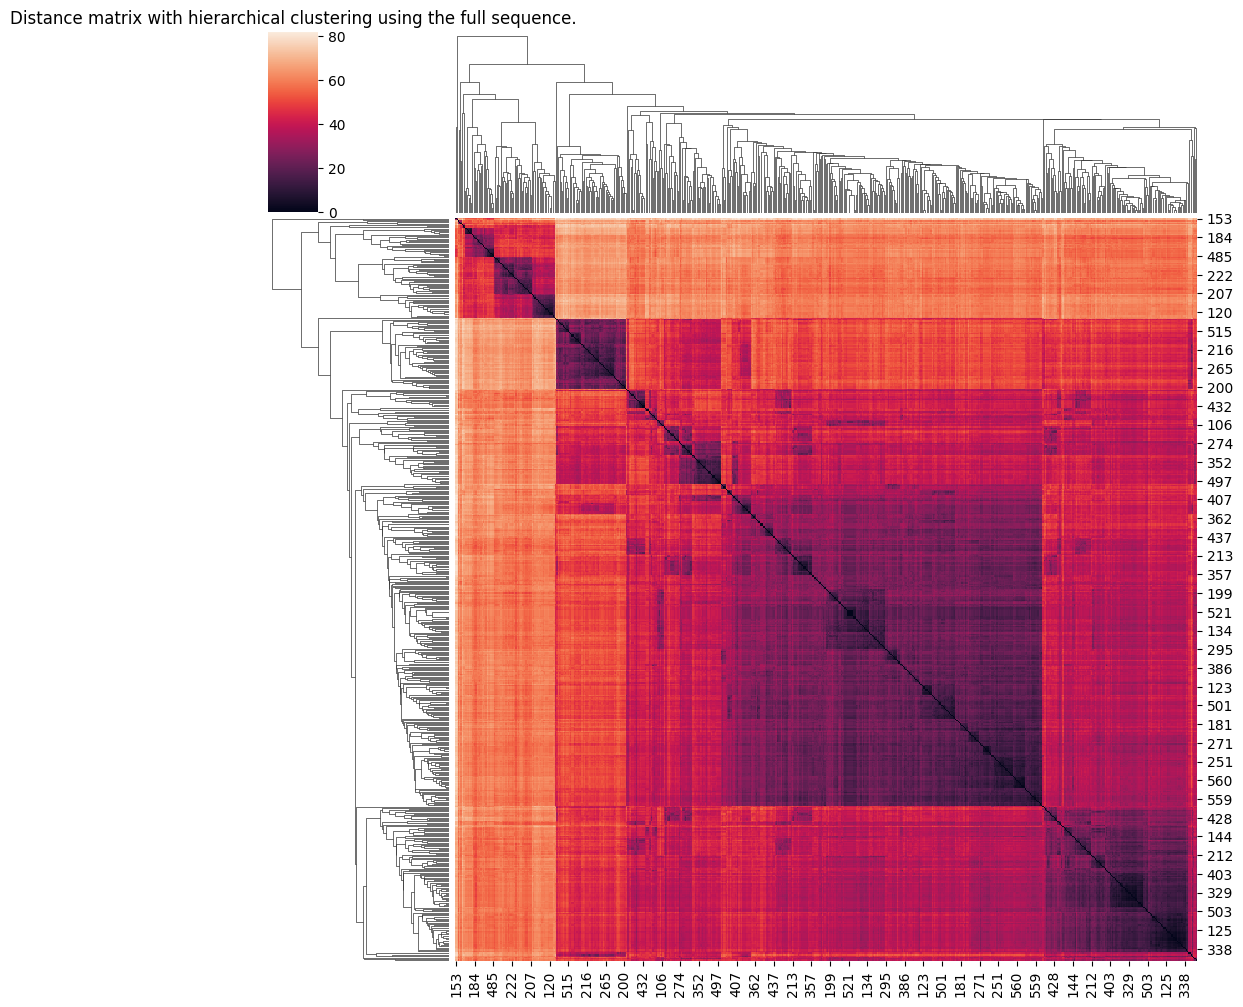

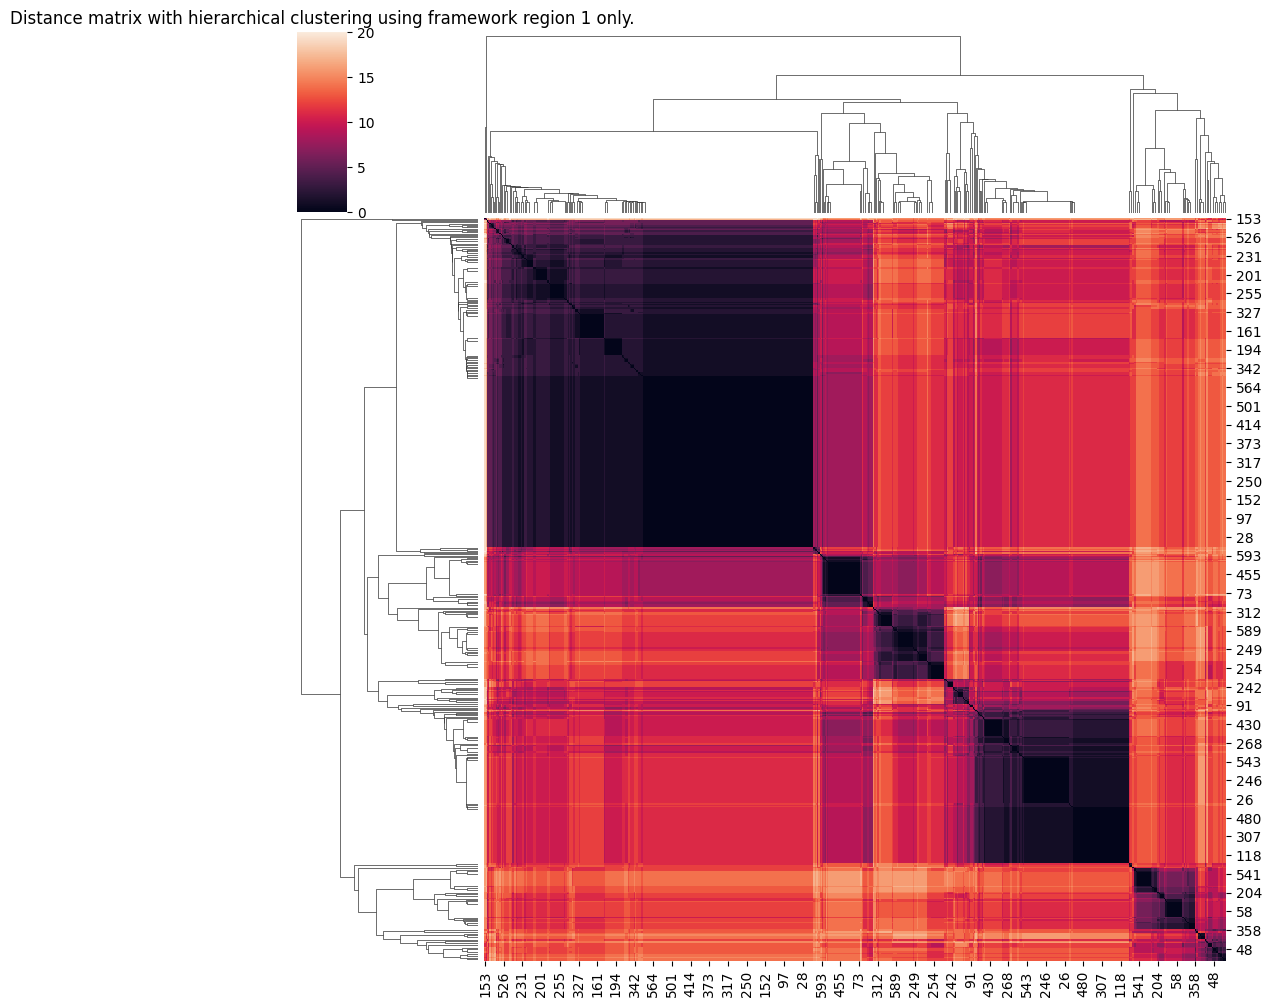

In [6]:
# Scipy likes to use condensed distance matrices which are created from regular distance matrices by calling squareform.
l1 = linkage(squareform(full_sequence_distance_matrix), "average")
l2 = linkage(squareform(framework_distance_matrix), "average")

sns.clustermap(full_sequence_distance_matrix, row_linkage=l1, col_linkage=l1)
plt.title("Distance matrix with hierarchical clustering using the full sequence.")
plt.show()

sns.clustermap(framework_distance_matrix, row_linkage=l2, col_linkage=l2)
plt.title("Distance matrix with hierarchical clustering using framework region 1 only.")
plt.show()

Notice how unsurprisingly it's easy to see some clear evidence of distinct groupings if we use framework region 1 only. Not so much using the full seequence. We'll create some cluster assignments for the framework using a somewhat arbitrary cut point:

In [7]:
fmwk_hclust_labels = fcluster(l2, t=10, criterion="distance")

Everything we've done above used distance matrices. Distance matrices however obviously have $N^2$ scaling with the number of datapoints, so it becomes completely impractical for more than a few thousand sequences. For this reason, AntPack also provides (as of v0.4) a highly scalable mixture model algorithm (we plan to add another algorithm as well) that can scale easily to tens of millions of sequences. It's generally not advisable to use this algorithm on small datasets because it will tend to select a number of clusters that is unnecessarily small, however for illustrative purposes we'll use this algorithm here to see how it compares to what we did before.

When using the mixture model, you can calculate BIC and AIC to determine the optimal number of clusters. These values penalize model complexity and also model accuracy, so there is a tradeoff: if the model is highly accurate but also has a large number of clusters or the input sequences are very long (hence lots of parameters), BIC and AIC will tend to prefer a slightly less accurate solution. We'll use BIC and AIC for illustrative purposes here.

Some useful tips:

It's ok to set a larger number of clusters a little larger than you need, because AntPack's mixture model can kill off unneeded clusters during fitting.

If the dataset is too large to load to memory and is stored in a (possibly gzipped) fasta file, use ``encode_fasta`` to encode it to temporary files in a location of your choice.

Multithreading will greatly speed up fitting because the model will then process multiple batches of data in parallel; to enable this, set the "max_threads" argument.

In [9]:
bic, aic = [], []

import time

st = time.time()
for proposed_number_clusters in [1,2,3,4,5,10,20,40]:
    # Notice that we can EITHER supply a sequence length OR the numbering for
    # our MSA. Supplying numbering allows us to select a subregion which is what
    # we want to do in this case, so that's what we'll do here. If we do that
    # the sequence_length argument is ignored. As for the distance matrix,
    # if we're supplying numbering and the region is not "all", we can supply
    # cdr scheme and region we'd like to extract to use just that region for clustering.
    em_cat_mixture = EMCategoricalMixture(n_components=proposed_number_clusters,
                                       numbering=msa_position_codes, chain_type="L",
                                          numbering_scheme="imgt", cdr_scheme="kabat",
                                          region="fmwk1", max_threads=3, verbose=False)
    # prune_after_fitting defaults to True and will kill off any empty clusters at the
    # end of fitting.
    em_cat_mixture.fit(sequences=msa, prune_after_fitting=True)
    bic.append(em_cat_mixture.BIC(msa))
    aic.append(em_cat_mixture.AIC(msa))
    print(proposed_number_clusters)

st = time.time() - st
print(f"That took about {st} seconds.")

1
2
3
4
5
10
20
40
That took about 0.14644503593444824 seconds.


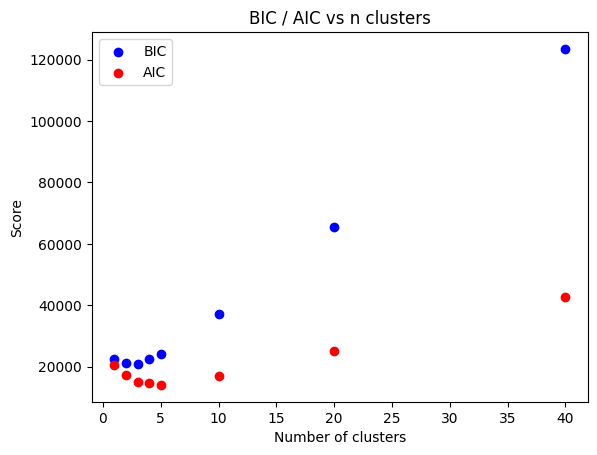

In [10]:
plt.scatter([1,2,3,4,5,10,20,40], bic, color="blue", label="BIC")
plt.scatter([1,2,3,4,5,10,20,40], aic, color="red", label="AIC")
plt.legend()
plt.title("BIC / AIC vs n clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Score")
plt.show()

Note that BIC is more conservative (this is always true). AIC prefers 5-10 clusters and BIC 3. Since this is a small dataset both metrics are probably discriminating in favor of fewer clusters than we actually truly need (that problem would be much worse if we tried to cluster the full sequence). There can be some "noise" because the model fits using EM which is an optimizer that finds a local maximum; multiple restarts (``fit`` defaults to 3) can help ensure it finds the GLOBAL maximum but this is still not guaranteed, so the curve is not perfectly smooth. We can use a little more clusters than we absolutely need, so let's fit using 6 for now.

In [11]:
em_cat_mixture = EMCategoricalMixture(n_components=6,
                                       numbering=msa_position_codes, chain_type="L",
                                          numbering_scheme="imgt", cdr_scheme="kabat",
                                          region="fmwk1", max_threads=3, verbose=False)
em_cat_mixture.fit(sequences=msa, prune_after_fitting=True)

If we need the raw model parameters for some reason we can retrieve them like this. These plot the probability of each
amino acid at each position so can sometimes be interesting to plot for diagnostic purposes or to better understand your data.

In [12]:
cluster_params, mix_weights = em_cat_mixture.get_model_parameters()

We can assign sequences to clusters and predict the log probability of a new sequence (we can even use this to build a simple classifier if we have sequences that belong to known classes). Let's see how to do that:

In [13]:
sequence_prob = em_cat_mixture.score(msa)
cluster_assignments = em_cat_mixture.predict(msa)

Let's see how well-correlated the clustering using linkage is with the categorical mixture. Keep in mind that each procedure will have used different cluster labels -- what we mostly want to see here is whether two sequences that are assigned to the same cluster in procedure A are assigned to the same cluster in procedure B.

Text(0.5, 0, 'Hierarchical clustering assignment')

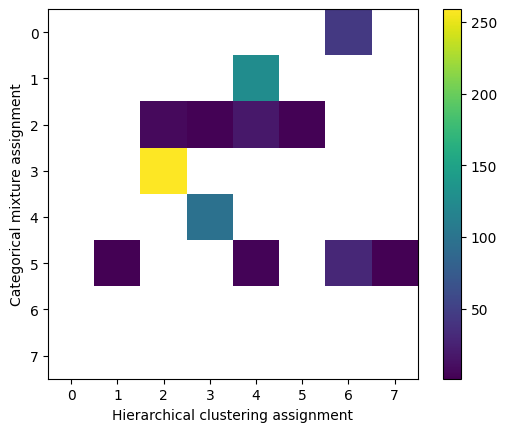

In [14]:
confmat = confusion_matrix(cluster_assignments, fmwk_hclust_labels).astype(np.float32)
confmat[confmat==0.]=np.nan
plt.imshow(confmat)
plt.colorbar()
plt.ylabel("Categorical mixture assignment")
plt.xlabel("Hierarchical clustering assignment")

We can quantify the strength of this correlation in various ways, but for now notice that for some of the well-defined clusters (3 in the hierarchical mixture labeling vs 4 in the mixture or 2 in hierarchical vs 3 in mixture) there's a fairly strong association -- the same sequences were generally assigned to the same clusters. For smaller clusters which based on the distance matrix are much more "scattered" in both models the association is not quite as strong as we'd expect.